# Galaxy Rotation Curves

To start with, I am going to look at the rotation curves of the galaxies with resolved stars. That is, the behaviour of stellar orbital velocities as a function of distance from the galactic center. Let's start by importing the names of each galaxy.

In [1]:
import os 

datapath = 'Sim Data (Clusters; 800, Seed; 9593)' # all of the data is within a folder in this .ipynb file's directory
GalaxyNames = []
for clusterFile in os.listdir(datapath + '/Star Clusters'):
    GalaxyNames.append(clusterFile[:-4]) # this gets the name of the cluster, without the `.txt' file extension

Now, we can import the data from a galaxy and see what the curve looks like. I'm going to create a function that will take in a galaxy name as a string, and then return arrays of the orbit velocities and apparent radii. 

In [2]:
import numpy as np
import pandas as pd

def importGalaxy(name):
    # read the data from the .txt file into a dataframe
    galaxdata = pd.read_csv(datapath + f'/Star Clusters/{name}.txt', delimiter=' ')
    galaxEquat, galaxPolar = np.mean(galaxdata['Equatorial']), np.mean(galaxdata['Polar']) # get the approx. center coords
    galaxVel = np.mean(galaxdata['RadialVelocity']) # get the approx. radial velocity of the galaxy as a whole
    # now subtract the mean velocity from each, and take the absolute value so we have a velocity magnitude
    orbitVels = abs(galaxdata['RadialVelocity'] - galaxVel).to_numpy()  
    # now to get the apparent radius of each star from the galactic center. We do this via the formula
    # r = sqrt([x - x_mean]^2 + [y - y_mean]^2)     for each star
    sqEquats = (galaxdata['Equatorial'] - galaxEquat)**2 
    sqPolars = (galaxdata['Polar'] - galaxPolar)**2 
    orbitRadii = np.sqrt(sqEquats + sqPolars).to_numpy()
    orbitRadii = orbitRadii / max(orbitRadii) # get the orbit radii relative to the galaxy radius
    return orbitRadii, orbitVels

With that done, let's plot the rotation curve of a galaxy!

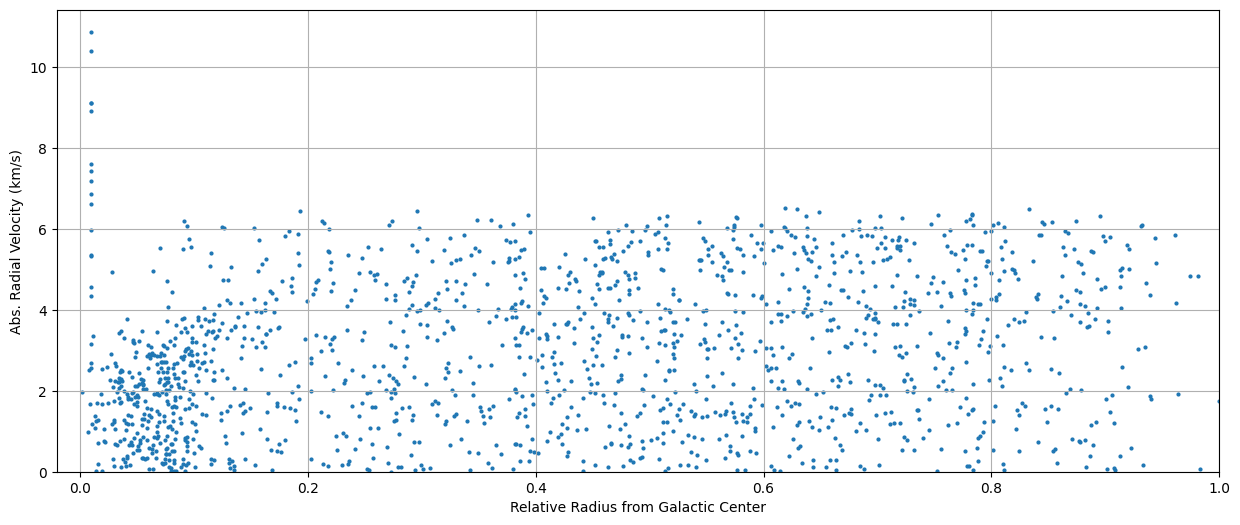

In [3]:
import matplotlib.pyplot as plt

orbitRadii, orbitVels = importGalaxy(GalaxyNames[7]) # this galaxy in particular has a nice curve

fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(orbitRadii, orbitVels, s=4)
ax.set_xlabel("Relative Radius from Galactic Center")
ax.set_ylabel("Abs. Radial Velocity (km/s)")
ax.set_ylim(ymin=0); ax.set_xlim(-0.02, 1)
ax.grid()

This is a really clean curve, and it looks like that there is *no* noise from other galaxies in the sky. We do, however, see a lot of points underneath a clear ceiling on the curve. This isn't an issue with the data, persay, but is a result of how the galaxy is oriented as we see it in the plane of the sky. Since the stars are moving in arbitrary direction about the galactic center, we will see varying magnitudes of radial velocities depending on whether they are moving directly towards or away from us. That is, the velocities of stars truly are a nice function of distance, it's just that they're moving in (more-or-less) random directions, and so their radial velocity is effectively random in the range of 0 to the true orbital velocity value. Here, the stars we see moving at the true orbital velocity are those moving approximately parallel with respect to our line of sight. 

With that in mind, the ceiling of the curve represents the true orbital velocity of stars at that (relative) galactic radius. If we're going to try to curve fit the data, we'll need to separate the ceiling of the data from the useless points that sit below the curve. To do this, I'll split the domain up into a number of segments and then take the maximum data point within that segment. This will, of course, ignore a bunch of the data points but we only need a few dozen data points to fit a curve with good confidence. 

In [4]:
def curveCeiling(radii, velocities):
    nSegments = 40 # number of segments to split the domain into
    ceilingRad, ceilingVels = np.zeros(nSegments), np.zeros(nSegments) # initialise some arrays
    for i in range(nSegments): # now iterate over the segments
        center = i * 1 / nSegments # get the center of the segment
        dr = 1/2 * 1/nSegments # and the width of the segment. This corresponds to dr = width / 2
        # now, get the indices of the data points within the area specified by center - dr <= x <= center + dr
        indices = np.argwhere(np.logical_and(center - dr <= radii, radii <= center + dr))
        rads = radii[indices] # get the orbital radii of these indices
        vels = velocities[indices] # as above, with velocities
        if len(rads) < 1: # if there is no data in this segment, we ignore it
            pass
        else: # otherwise, find the maximum velocity, and record its value and the corresponding orbital radius
            maxIndex = np.argmax(vels)
            ceilingRad[i] = rads[maxIndex]
            ceilingVels[i] = vels[maxIndex]
    
    ceilingRad = ceilingRad[np.nonzero(ceilingVels)] # this cleans up the domains where we didn't see any data points
    ceilingVels = ceilingVels[np.nonzero(ceilingVels)]
    
    return ceilingRad, ceilingVels

And with that, we can look at the results of the ceiling finder.

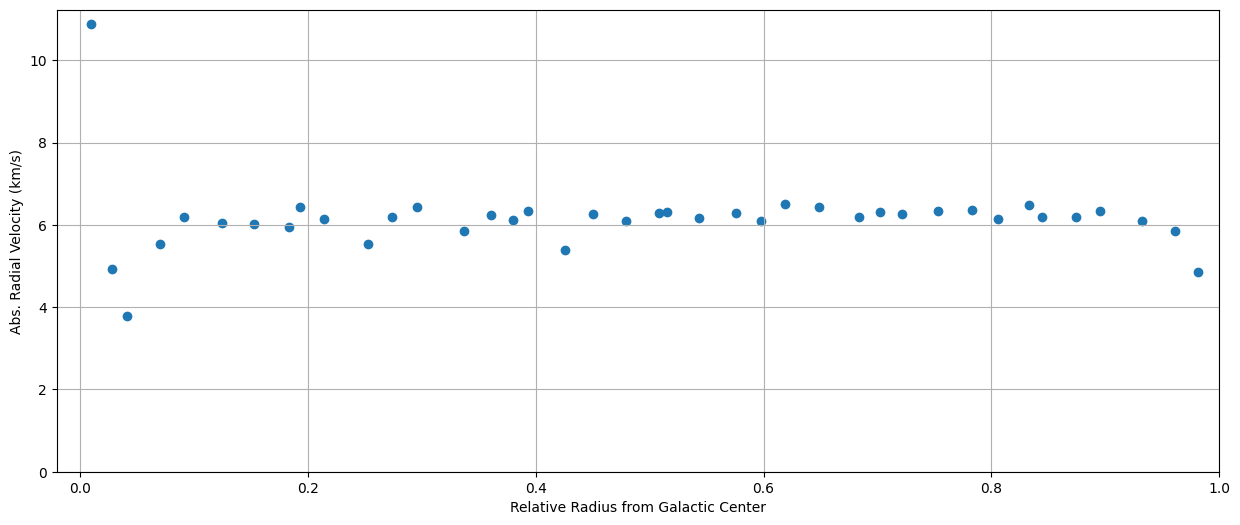

In [5]:
sortRad, sortVels = curveCeiling(orbitRadii, orbitVels)

fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(sortRad, sortVels)
ax.set_xlabel("Relative Radius from Galactic Center")
ax.set_ylabel("Abs. Radial Velocity (km/s)")
ax.set_ylim(ymin=0); ax.set_xlim(-0.02, 1)
ax.grid()

## Fitting Curves to the Data
For this shape of data, we should be able to get a decent fitting curve with a polynomial function of the form 
$$V \sim aR^{-2} + b \sqrt{R} + cR$$
This has some physical relevance. For low $R$, we want the velocity to increase sharply due to the presence of some compact matter in the galactic core. This corresponds to the $aR^{-2}$ term, which is large at tiny $R$. 

For middle $R$ values, we want the curve to rise logarithmically or as a root. Physically, this corresponds to some gradual increase in mass with increasing $R$ -- possibly evidence of dark matter!

For large $R$ values, we want the curve to come back down to $V \sim 0$. Physically, this corresponds to radii far from the galaxy and so far from the mass that drives orbital speeds. As long as the coefficient is negative, a $cR$ term is suitable here. 

Now, let's curve fit. I claim that this rotation curve is characterised by a black hole at small $R$ and dark matter at large $R$, so I'll call this function the BHDM curve.

In [6]:
def BHDMCurve(r, a, b, c):
    return a * r**-2 + b * np.sqrt(r) + c * r

Now to fit the data using this curve. 

a=0.0008949525718193274, b=19.332, c=-14.042


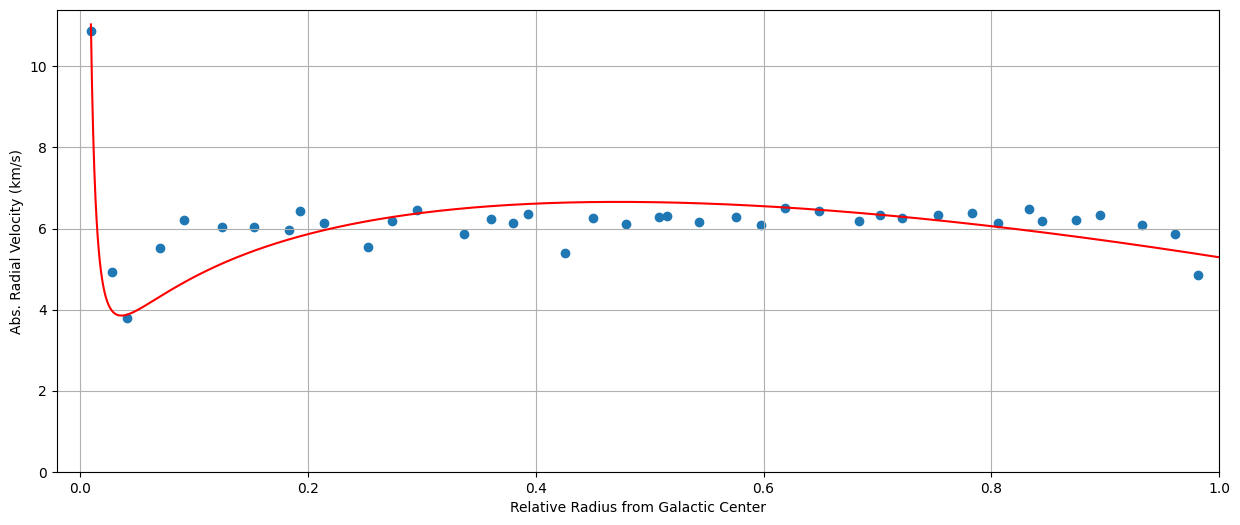

In [7]:
from scipy.optimize import curve_fit
coefficients, params = curve_fit(BHDMCurve, sortRad, sortVels, p0=[0.01, 2, -1])
a, b, c = coefficients
print(f"{a=}, {b=:.3f}, {c=:.3f}")
X = np.linspace(min(sortRad), 1, 1000)
fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(sortRad, sortVels)
ax.plot(X, BHDMCurve(X, a, b, c), c='r')
ax.grid()
ax.set_xlabel("Relative Radius from Galactic Center")
ax.set_ylabel("Abs. Radial Velocity (km/s)")
ax.set_ylim(ymin=0); ax.set_xlim(-0.02, 1);

Looks like a good fit! 

Since I have seen the answers, I know that there are other rotation curve types within this universe. I'll plot a few now!

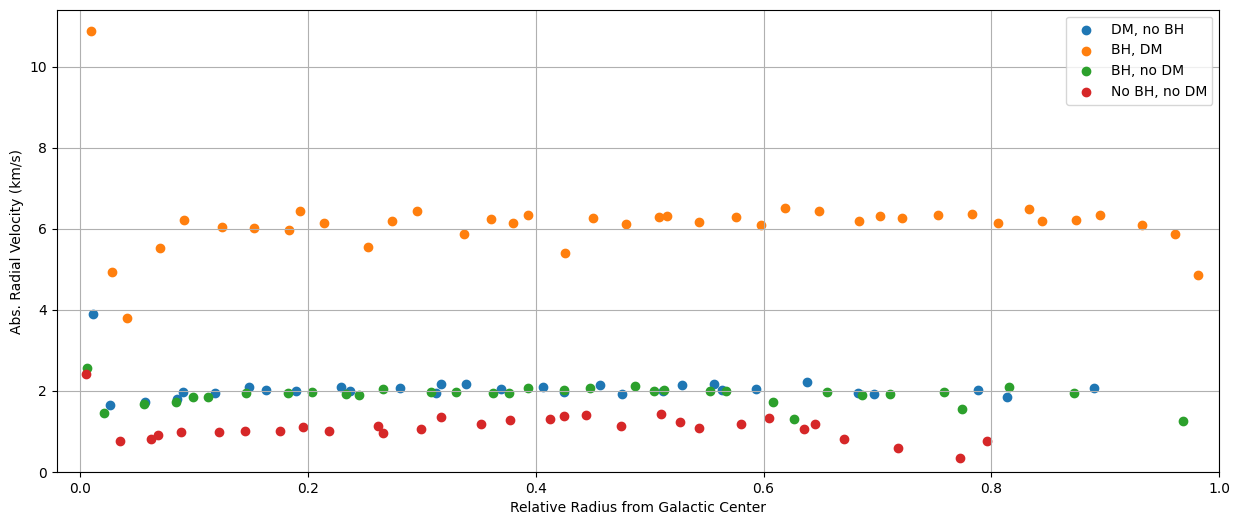

In [11]:
fig, ax = plt.subplots(figsize=(15, 6))
# I've hand picked some galaxies here, to show the different rotation curve types.
labels = ["DM, no BH", 'BH, DM', 'BH, no DM', 'No BH, no DM'] # labels for each curve
for i, num in enumerate([1, 7, 8, 11]): 
    name = GalaxyNames[num] # find the galaxy name
    orbitRadii, orbitVels = importGalaxy(name) # import data
    sortRad, sortVels = curveCeiling(orbitRadii, orbitVels) # find data ceiling
    ax.scatter(sortRad, sortVels, label = labels[i]) # and plot with the label

ax.grid(); ax.legend(loc='upper right');
ax.set_xlabel("Relative Radius from Galactic Center")
ax.set_ylabel("Abs. Radial Velocity (km/s)")
ax.set_ylim(ymin=0); ax.set_xlim(-0.02, 1);

Now, I'm going to make a different curve function for galaxies with no black hole. 

In [ ]:
def DMCurve(r, a, b, c):
    return a * (r)**b + c * r

And now let's see how it deals with galaxies with dark matter and no dark matter...

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
fig.subplots_adjust(wspace=0)
X = np.linspace(0, 1, 1000)
labels = ["Dark Matter", "No Dark Matter"]
for i, name in enumerate([GalaxyNames[2], "X016.4-Y060.6-N1140"]):
    orbitRadii, orbitVels = importGalaxy(name) # import data
    sortRad, sortVels = curveCeiling(orbitRadii, orbitVels)
    coefficients, params = curve_fit(DMCurve, sortRad, sortVels, p0=[0.01, 0.5, 1])
    a, b, c = coefficients
    ax[i].scatter(sortRad, sortVels)
    ax[i].plot(X, DMCurve(X, a, b, c), c='r', label=labels[i])
    ax[i].grid(); ax[i].legend(loc='lower right')
    
ax[0].set_xlim(-0.02, 1)
ax[0].set_ylabel("Abs. Radial Velocity (km/s)")
ax[0].set_ylim(ymin=0)
fig.supxlabel("Relative Radius from Galactic Center");

These look like pretty good fits to the data! 

Of course, some of the data sets are extremely noisy since the clustering algorithm (that was used to find the galaxies) is not perfect. Typically, particularly noisy data looks like the following:

In [ ]:
orbitRadii, orbitVels = importGalaxy(GalaxyNames[3]) # this galaxy in particular has a nice curve

fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(orbitRadii, orbitVels, s=4)
ax.set_xlabel("Relative Radius from Galactic Center")
ax.set_ylabel("Abs. Radial Velocity (km/s)")
ax.set_ylim(ymin=0); ax.set_xlim(-0.02, 1)
ax.grid()

There is a good rotation curve hidden in there, but it is marred presumably by stars of another galaxy that aren't reduced by our techniques. In this case, it would be best to ignore this (and galaxies like this), since we have so many good data sets at our disposal. 

## Rotation Curves in General
As a culmination of everything done so far, I am now going to plot (normalised) rotation curves over each other, ignoring the noisy data sets. In doing this, we can see in general how stars orbit in their galaxies. 

In [ ]:
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')  # this code is going to give some RuntimeWarnings that I don't care about!

fig, ax = plt.subplots(figsize=(16, 6))

for i, name in enumerate(GalaxyNames):
    # a lot of the curves won't fit, which will generate an error. Hence, i need a try/except block to avoid
    # the program dying before we can fit 
    try:
        orbitRadii, orbitVels = importGalaxy(name)
        sortRad, sortVels = curveCeiling(orbitRadii, orbitVels)
        
        (DMa, DMb, DMc), params = curve_fit(DMCurve, sortRad, sortVels, p0=[0.01, 0.5, 1])
        yDM = DMCurve(sortRad, DMa, DMb, DMc)
        r2DM = r2_score(sortVels, yDM)
        
        (BHa, BHb, BHc), params = curve_fit(BHDMCurve, sortRad, sortVels, p0=[0.01, 2, -1])
        yBH = BHDMCurve(sortRad, BHa, BHb, BHc)
        r2BH = r2_score(sortVels, yBH)
        
        if max([r2BH, r2DM]) > 0.8:
            X = np.linspace(min(sortRad), 1, 1000)
            if r2BH > r2DM:
                Y = BHDMCurve(X, BHa, BHb, BHc)
            else:
                Y = DMCurve(X, DMa, DMb, DMc)
            ax.plot(X, Y / max(Y), c='g', alpha=0.1)
    except RuntimeError:
        pass
    
ax.set_xlim(-0.02, 1)
ax.set_ylabel("Relative Radial Velocity (prop of $V_{max}$)")
ax.set_ylim(ymin=0, ymax=1.01)

ax.set_xlabel("Relative Radius from Galactic Center");

It's a bit of a mess, but we can see that the vast majority of galaxies seem to have a black hole in their centers, and some amount of dark matter which keeps their rotation curves relatively flat. 

# Cluster Rotation Curves